---
title: "Hygge Web Data - Cozy Content Filtering for a finer Scandinavian FineWeb"
description: "Building and evaluating efficient, disposable content filtering models for Scandinavian language texts using the FineWeb-c dataset to improve data quality"
author: "Daniel van Strien"
date: "2025-01-13"
categories: ["polars", "huggingface", "fineweb", "data"]
image: https://huggingface.co/datasets/HuggingFaceFW/admin/resolve/main/fineweb-2-logo.png
toc-depth: 3
toc: true
---

# How and why to curate Web Scale Data

> The performance of a large language model (LLM) depends heavily on the quality and size of its pretraining dataset. - [FineWeb blog post](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1)

Whilst quality is important, the quantity of data we start with is significant. For example the original [FineWeb-2](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1) dataset contains 15 trillion tokens (44TB on disk).

The challenge is then: how can we curate data for LLMs in a scalable way? One possible approach is to use LLMs to help with labelling text. Whilst LLMs can do well on this kind of task (especially when using Structured Generation), scaling LLM labeling to web scale is a challenge. 

Last year, [FineWeb-Edu](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1) showed that filtering data for educational quality could yield improvements for LLMs trained on this filtered data. The approach they took was to first use an LLM to label a subset of data and then use a fine-tuned a much smaller BERT-based model to filter the data. 

The publication of [ModernBert](https://huggingface.co/blog/modernbert) has shown that there is still a lot of excitement around the use of smaller encoder-based models for labelling tasks, indeed one of the examples they cite in their blog post is the cost of creating FineWeb-Edu if they had used a decoder-only model.

> An interesting example is FineWeb-Edu, where model-based quality filtering had to be performed over 15 trillion tokens. The FineWeb-Edu team chose to generate annotations with a decoder-only model, Llama-3-70b-Instruct, and perform the bulk of the filtering with a fine-tuned BERT-based model. This filtering took 6,000 H100 hours, which, at HuggingFace Inference Endpoints' pricing of $10/hour, comes to a total of $60,000. On the other hand, feeding 15 trillion tokens to popular decoder-only models, even with the lowest-cost option of using Google's Gemini Flash and its low inference cost of $0.075/million tokens, would cost over one million dollars! [ModernBert blog post](https://huggingface.co/blog/modernbert)

The ideal approach then seems to be something like:

- Use an LLM to label a subset of data and use these labels to train a smaller model
- Use a smaller model to make prediction on a large dataset and use these predictions to filter the data
- Profit! 

While this may work well for English data, many papers have shown that the performance of LLMs for these kinds of tasks can be much worse than for English. 

This is where the [FineWeb-c dataset](https://huggingface.co/posts/davanstrien/616684712874803) comes in.

# The FineWeb-C dataset

[FineWeb-C](https://huggingface.co/blog/davanstrien/fineweb2-community) is a community-driven initiative to help create high-quality datasets for training LLMs in multiple languages. Rather than relying solely on LLM-based labeling (which may perform poorly in non-English languages), the FineWeb-C project leverages the Hugging Face community to annotate texts for educational quality across different languages. The project has seen significant growth, achieving:

- Over 48,000 total annotations
- Coverage of 114 different languages
- Contributions from 400+ annotators

You can contribute using your Hugging Face account here: [https://huggingface.co/spaces/data-is-better-together/fineweb-c](https://huggingface.co/spaces/data-is-better-together/fineweb-c)

The project has already released several versions of the [dataset](https://huggingface.co/datasets/data-is-better-together/fineweb-c), currently covering 18 languages that have reached the 1,000 annotations threshold (this number keeps growing thanks to the community's rapid contributions!). This community-driven approach helps ensure that data quality assessment isn't limited by the capabilities of existing LLMs, particularly for lower-resource languages.

In a previous [blog post](https://danielvanstrien.xyz/posts/2024/12/23/fineweb-filter-polars.html), I discussed using Polars to filter out problematic content from the FineWeb-C dataset using rules and heuristics. While this approach can be effective with well-defined rules, I also examined the current annotated dataset [in this post](https://danielvanstrien.xyz/posts/2025/FineWeb-c/how-fine-is-fineweb2), which showed that some languages may already have sufficient annotated data to train a content filtering model.

In this post, we'll explore using the FineWeb-C dataset to train a model that can help curate the [FineWeb-2 dataset](https://huggingface.co/datasets/HuggingFaceFW/fineweb-2).

# Training a classifier to help curate the FineWeb-2 dataset

The long term goal of FineWeb-C is to create a dataset that can help reproduce FineWeb-Edu for many languages. This basically means we need some data for training a model(s) to label the educational quality of text data. Let's look at the data the community has created so far to see what we can already do with the data. 

First we install the necessary libraries. 

In [1]:
# | output: false
%pip install polars datasets accelerate evaluate transformers torch huggingface_hub scikit-learn tensorboard wandb matplotlib --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 224.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 244.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 79.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 193.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 273.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 332.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 189.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 232.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 339.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 330.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 368.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 340.9 MB/

In [3]:
# | code-fold: true
import numpy as np
import polars as pl
from datasets import Dataset, DatasetDict
from huggingface_hub import list_repo_files
from scipy.special import softmax
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

## Understand the data 


We'll load the dataset from the Hugging Face Hub using Polars which supports [loading data from the Hub](https://huggingface.co/docs/hub/en/datasets-polars).

In this case, we'll load the "default" config which contains all the languages that have reached the 1,000 annotations threshold.


In [4]:
df = pl.read_parquet("hf://datasets/data-is-better-together/fineweb-c/data/*.parquet")
df = df.lazy()

In [5]:
df.select("language_code").unique().collect().to_series().to_list()

['lvs_Latn',
 'swe_Latn',
 'cmn_Hani',
 'fra_Latn',
 'tat_Cyrl',
 'ukr_Cyrl',
 'arz_Arab',
 'hin_Deva',
 'yue_Hani',
 'zsm_Latn',
 'fas_Arab',
 'vie_Latn',
 'slk_Latn',
 'gmh_Latn',
 'dan_Latn',
 'spa_Latn',
 'rus_Cyrl',
 'ary_Arab',
 'bar_Latn',
 'fin_Latn',
 'fil_Latn',
 'asm_Latn',
 'arb_Arab']

## Can we train a model to work with a subset of languages?

So far we have 18 languages in the dataset. Currently over a 100 languages have some level of annotation so eventually we hope the community will create a dataset for ma
ne model per language.

Claude gave me the following visual for languages groups in this dataset (which isn't super accurate but gives a rough idea of the language families represented in the dataset).

![Color-coded grid visualization of 20 languages organized by 8 language families](assets/language-families-names.svg){#fig-languages fig-alt="Color-coded grid visualization of 20 languages organized by 8 language families (Indo-European, Sino-Tibetan, Austronesian, Uralic, Turkic, Austro-Asiatic, Afroasiatic, Indo-Aryan) and their subgroups, with language codes shown in monospace font" fig-cap="Language families represented in the FineWeb-C dataset"}

We can see a few possible language groups that it *could* make sense to train a model on. One potential group is the Germanic languages. Let's look at the data for these languages.

::: {.callout-note}
I focused on Germanic languages to start with as if I squint I can get a rough understanding of the language. I would be very excited to see the community begin to explore all of the languages in the dataset.
:::

In [5]:
germanic_languages = ["gmh_Latn", "dan_Latn", "swe_Latn", "bar_Latn", "lvs_Latn"]

## What do we want to label?

While the overarching goal of the FineWeb-C project is to create a dataset for training models to label the educational quality of text, in order to effectively train this kind of model we need a reasonable distribution of labels.

### Problematic content?

The annotation interface for FineWeb-c looks something like this (using Scots as an example). 

![Annotation interface for Scots](assets/annotation_example.png)

For this example, the annotator could mostly focus on how educational the text is. However, this is the web we're annotating so we will sometimes come across "problematic" content. This content is usually content in the wrong language i.e. the language predicted during the FineWeb-2 extraction process is incorrect (this happens quite a lot for some languages and much less for others) or the content is garbled in some way. An example of this kind of content is shown below.

![Problematic content example](assets/problematic_example.png)

We can see that the content is in the wrong language (English) the text is also somewhat garbled 


::: {.callout-note}
Why aren't these just labeled as `None` i.e. no educational value? Annotating data always comes with some ambiguity. In this case, we added a `problematic` label to try and make it easier for the community to flag content that was incorrect in some other way. We could have added a whole separate label for this and for the different possible types of issue but this adds extra cognitive load for the annotator. We can also deal with possible overlap in usage of these labels in other ways. 
:::

Before we dive into training an educational quality classifier, let's look at the data for the Germanic languages and see how often this problematic content is present. We're using Polars in Lazy mode but it's not really necessary for the size of the dataset at the moment. In the future the dataset might become large enough that this can be more important.

In [6]:
df_germanic = df.filter(pl.col("language_code").is_in(germanic_languages))

Let's start by seeing the percentage of problematic content for each language in the "germanic" group. 

In [7]:
(
    df_germanic.group_by("language_code")
    .agg(
        [
            (
                pl.col("problematic_content_label_present").sum()
                / pl.col("problematic_content_label_present").count()
                * 100
            ).alias("problematic_percentage")
        ]
    )
    .sort("problematic_percentage", descending=True)
).collect()

language_code,problematic_percentage
str,f64
"""gmh_Latn""",98.3
"""bar_Latn""",77.0
"""dan_Latn""",19.4
"""swe_Latn""",8.8
"""lvs_Latn""",8.7


We can see that for some of the languages in this group the percentage of problematic content is very high. In particular Bavarian and Middle High German have a very high percentage of problematic content. The other languages have a much lower percentage of problematic content. 

### Making the lives of annotators easier and getting more educational?

While we could jump to training a model to label the educational quality of the text, we may wan to start in a more modest way. In my previous [blog post](https://danielvanstrien.xyz/posts/2025/FineWeb-c/how-fine-is-fineweb2) I generated this plot showing the distribution of educational value for languages in the dataset. 

![Label distribution by language](https://danielvanstrien.xyz/posts/2025/FineWeb-c/how-fine-is-fineweb2_files/figure-html/cell-11-output-1.png)

While some languages have a fairly good distribution of educational value labels, most have very few examples of "Excellent" educational quality content. This is not surprising – the majority of the web is not educational...

For languages with very few examples of any educational content training a classifier to label the educational quality of the text is not going to work well. For these languages we probably want to first focus on being able to remove problematic content so we reduce the amount of "noise" annotators need to spend time on and then can instead focus on labelling content that is *more* likely to be educational. 

For this we'll train a model to label problematic content. We'll start with the Scandinavian languages since we have Danish and Swedish datasets completed and these languages are somewhat similar (don't come at me Danish and Swedish speaker – I've watched the [Bridge!](https://en.wikipedia.org/wiki/The_Bridge_(2011_TV_series)))

::: {.callout-note}
This is not the only approach we could take but it could be a good starting point. Even if we don't end up with sufficient data to train a model to label the educational quality of the text, we can still use this model to remove problematic content and improve the quality of the data we have for some languages.
:::

## Training out hygge model

Let's start by loading the data for the Scandinavian languages.


In [8]:
scandinavian_languages = ["swe_Latn", "dan_Latn"]

In [9]:
df_scandinavian = df.filter(pl.col("language_code").is_in(scandinavian_languages))

We can see that we have 1,000 annotations for each language. 


In [10]:
df_scandinavian.collect().shape

(2000, 8)

Now let's get a better understanding of the data. Swedish and Danish both have multiple annotations for many of the texts. This means multiple annotators have looked at the same text and given their assessment of the educational value. Let's take a look at some examples where the annotators disagree i.e. gave different labels. 


In [11]:
df_scandinavian.filter(
    pl.col("educational_value_labels").list.unique().list.len() > 1
).collect()

id,text,educational_value_labels,annotator_ids,problematic_content_label_present,problematic_content_label_agreement,language_names,language_code
str,str,list[str],list[str],bool,f64,str,str
"""d0347a16-14a6-40c7-a1b8-3d27b9…","""Virkelige får de vil ha sjæl o…","[""❗ Problematic Content ❗"", ""None"", ""❗ Problematic Content ❗""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""85ac8d54-89c5-4473-95c4-797366f03cd0"", ""e9f72b47-2af5-4b06-90f2-7163de147a1d""]",true,0.666667,"""dan_Latn""","""dan_Latn"""
"""ec7699c9-78e2-48ef-945e-9b0a71…","""Alle drømmer om den store gevi…","[""None"", ""Minimal"", ""Basic""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""85ac8d54-89c5-4473-95c4-797366f03cd0"", ""9987848b-debb-4ed3-a97b-14eb9b3c4322""]",false,1.0,"""dan_Latn""","""dan_Latn"""
"""49de8369-2b33-47d2-a877-2fe32b…","""Der er en elektrisk forbindels…","[""Basic"", ""None"", ""None""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""b98b0144-391d-4e70-bae0-743ce94e6314"", ""85ac8d54-89c5-4473-95c4-797366f03cd0""]",false,1.0,"""dan_Latn""","""dan_Latn"""
"""b20402d1-8250-410c-b177-966b8b…","""Online shopping råd - Levering…","[""Basic"", ""Minimal""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""85ac8d54-89c5-4473-95c4-797366f03cd0""]",false,1.0,"""dan_Latn""","""dan_Latn"""
"""dc34ee93-74e2-48ba-9b5c-9d4dfb…","""Morgenmad er det vigtigste mål…","[""Basic"", ""Basic"", ""None""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""85ac8d54-89c5-4473-95c4-797366f03cd0"", ""4e0a264e-6445-495f-ae54-8e0755b8ebd0""]",false,1.0,"""dan_Latn""","""dan_Latn"""
…,…,…,…,…,…,…,…
"""aee9b105-18c3-455d-b07c-545eb2…","""Dronning Victoria afskyede sin…","[""Minimal"", ""None"", ""❗ Problematic Content ❗""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""9987848b-debb-4ed3-a97b-14eb9b3c4322"", ""85ac8d54-89c5-4473-95c4-797366f03cd0""]",true,0.333333,"""dan_Latn""","""dan_Latn"""
"""42abb527-d3b8-4b23-b88a-d3df06…","""Smarte Opbevaringsløsninger ti…","[""Minimal"", ""None""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""85ac8d54-89c5-4473-95c4-797366f03cd0""]",false,1.0,"""dan_Latn""","""dan_Latn"""
"""7076624a-7b72-4534-bfdc-a4b6fc…","""Power Automate er under udbred…","[""Basic"", ""None"", ""Minimal""]","[""a0585a5c-b72f-4c3a-a2a3-17e8e0b4ea4f"", ""740270b9-61bf-4d85-a495-9e37270f7257"", ""82197ecd-6d0b-400a-834a-703da28164ae""]",false,1.0,"""dan_Latn""","""dan_Latn"""


Even with a quick eyeball we can see that often "problematic" or None are used to label the same text. Similarly "minimal" or "none" are used to label the same text. This isn't so surprising since the educational quality is fairly subjective. The main thing we probably don't want too much of is content with very extreme labels i.e None vs Excellent. We can take a closer look at the combinations of labels that are used. Let's take a look at the unique combinations of non agreeing labels. 

In [12]:
#| code-fold: true
(
    df_scandinavian.filter(
        pl.col("educational_value_labels").list.unique().list.len() > 1
    )
    .select(
        pl.col("educational_value_labels").list.sort().alias("educational_value_labels")
    )
    .unique()
).collect()

educational_value_labels
list[str]
"[""Basic"", ""Good"", ""None""]"
"[""Good"", ""None"", ""❗ Problematic Content ❗""]"
"[""Excellent"", ""Minimal"", ""Minimal""]"
"[""Basic"", ""Excellent"", ""Minimal""]"
"[""Basic"", ""None"", ""None""]"
…
"[""Good"", ""None"", ""None""]"
"[""Minimal"", ""None"", ""❗ Problematic Content ❗""]"
"[""Basic"", ""Minimal"", ""❗ Problematic Content ❗""]"


From a quick eyeball we don't seem to have disagreement that is too extreme. Let's get a better understanding of the co-occurrence of labels when annotators disagree.
 

In [13]:
#| code-fold: true
combinations = (
    (
        df_scandinavian.filter(
            pl.col("educational_value_labels").list.unique().list.len() > 1
        )
        .select(
            pl.col("educational_value_labels")
            .list.unique()
            .list.sort()
            .alias("educational_value_labels")
        )
        .collect()
    )
    .to_series()
    .to_list()
)
combinations[:10]

[['None', '❗ Problematic Content ❗'],
 ['Basic', 'Minimal', 'None'],
 ['Basic', 'None'],
 ['Basic', 'Minimal'],
 ['Basic', 'None'],
 ['Basic', 'None'],
 ['Basic', 'Minimal', 'None'],
 ['None', '❗ Problematic Content ❗'],
 ['None', '❗ Problematic Content ❗'],
 ['Minimal', 'None']]

We can plot this using some code Claude gave me. 


In [14]:
#| code-fold: true
import numpy as np
import pandas as pd

# First, let's get all unique labels that appear
all_labels = set()
for combo in combinations:  # combinations is your list of lists
    all_labels.update(combo)
all_labels = sorted(list(all_labels))

# Create a co-occurrence matrix
cooc_matrix = pd.DataFrame(0, index=all_labels, columns=all_labels)

# Fill the matrix
for combo in combinations:
    for label1 in combo:
        for label2 in combo:
            if label1 != label2:
                cooc_matrix.loc[label1, label2] += 1

# Convert to percentage of times labels co-occur
total_occurrences = cooc_matrix.sum().sum()
cooc_matrix_pct = cooc_matrix / total_occurrences * 100

# Print most common co-occurrences
pairs = []
for i in range(len(all_labels)):
    for j in range(i + 1, len(all_labels)):
        label1, label2 = all_labels[i], all_labels[j]
        count = cooc_matrix.loc[label1, label2]
        if count > 0:
            pairs.append((label1, label2, count))

# Sort by count
pairs.sort(key=lambda x: x[2], reverse=True)

# Print top co-occurrences
print("Most common label combinations:")
for label1, label2, count in pairs[:10]:
    print(f"{label1} + {label2}: {count} occurrences")

Most common label combinations:
Minimal + None: 305 occurrences
Basic + Minimal: 96 occurrences
None + ❗ Problematic Content ❗: 84 occurrences
Basic + None: 69 occurrences
Good + Minimal: 24 occurrences
Minimal + ❗ Problematic Content ❗: 23 occurrences
Good + None: 12 occurrences
Basic + Good: 11 occurrences
Basic + ❗ Problematic Content ❗: 7 occurrences
Basic + Excellent: 5 occurrences


We see here that Minimal and None are the most common labels when annotators disagree. We also see some "problematic" labels with None. In the FineWeb-c dataset the `problematic_content_label_present` is a boolean column that is `True` if any of the annotators labeled the text as problematic. We want to check that this wouldn't capture too many examples where another annotator would rate the text highly. If we train a classifier to remove problematic content is *may* also remove some examples which would be labelled None or possibly minimal but since we're mostly seeking to get higher educational quality data this isn't really a problem. 

## Preparing the data for training

Let's remind ourselves of the percentage of problematic content for each language we're working with. 


In [15]:
#| code-fold: true
(
    df_scandinavian.group_by("language_code").agg(
        [
            (
                pl.col("problematic_content_label_present").sum()
                / pl.col("problematic_content_label_present").count()
                * 100
            ).alias("problematic_percentage")
        ]
    )
).collect()

language_code,problematic_percentage
str,f64
"""swe_Latn""",8.8
"""dan_Latn""",19.4


Let's now convert our LazyFrame to a Polars DataFrame so it's a bit easier to pass to other libraries. 

In [16]:
df_scandinavian = df_scandinavian.collect()

### Train / test split

Creating a good train/test split is important for making sure we train a model that generalizes well. We'll use a stratified split to ensure that the train and test set have a similar distribution of labels. Since we're working with two language we probably want to stratify on language too.

In [17]:
#| code-fold: true
# Create stratification column
df_scandinavian = df_scandinavian.with_columns(
    strat_col=pl.col("language_code")
    + "_"
    + pl.col("problematic_content_label_present").cast(pl.Utf8)
)

# Convert to numpy for sklearn
X = df_scandinavian.select(["id", "text"]).to_numpy()  # Including id for tracking
y = df_scandinavian.select("problematic_content_label_present").to_numpy()
strat = df_scandinavian.select("strat_col").to_numpy()

# Create stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=strat, random_state=42
)

# Convert back to Polars DataFrames with all relevant columns
train_indices = set(X_train[:, 0])  # Assuming first column is id
test_indices = set(X_test[:, 0])

train_df = df_scandinavian.filter(pl.col("id").is_in(train_indices))
test_df = df_scandinavian.filter(pl.col("id").is_in(test_indices))

Let's take a look at the distribution of labels in the train and test set by language and label (problematic or not). 


In [18]:
#| code-fold: true
print("\nTrain Set:")
# Problematic content percentage by language
print("Label distribution within each language:")
print(
    (
        train_df.group_by("language_code")
        .agg(
            [
                (
                    pl.col("problematic_content_label_present").sum()
                    / pl.col("problematic_content_label_present").count()
                    * 100
                ).alias("problematic_percentage"),
                pl.col("problematic_content_label_present")
                .count()
                .alias("total_count"),
            ]
        )
        .sort("language_code")
        .with_columns(pl.col("problematic_percentage").round(2))
    )
)

# Language distribution
print("\nLanguage distribution in train set:")
print(
    (
        train_df.group_by("language_code")
        .agg(
            (pl.len() / train_df.height * 100).alias("percentage_of_split"),
            pl.len().alias("count"),
        )
        .sort("language_code")
        .with_columns(pl.col("percentage_of_split").round(2))
    )
)

print("\nTest Set:")
# Problematic content percentage by language
print("Label distribution within each language:")
print(
    (
        test_df.group_by("language_code")
        .agg(
            [
                (
                    pl.col("problematic_content_label_present").sum()
                    / pl.col("problematic_content_label_present").count()
                    * 100
                ).alias("problematic_percentage"),
                pl.col("problematic_content_label_present")
                .count()
                .alias("total_count"),
            ]
        )
        .sort("language_code")
        .with_columns(pl.col("problematic_percentage").round(2))
    )
)

# Language distribution
print("\nLanguage distribution in test set:")
print(
    (
        test_df.group_by("language_code")
        .agg(
            (pl.len() / test_df.height * 100).alias("percentage_of_split"),
            pl.len().alias("count"),
        )
        .sort("language_code")
        .with_columns(pl.col("percentage_of_split").round(2))
    )
)


Train Set:
Label distribution within each language:
shape: (2, 3)
┌───────────────┬────────────────────────┬─────────────┐
│ language_code ┆ problematic_percentage ┆ total_count │
│ ---           ┆ ---                    ┆ ---         │
│ str           ┆ f64                    ┆ u32         │
╞═══════════════╪════════════════════════╪═════════════╡
│ dan_Latn      ┆ 19.38                  ┆ 800         │
│ swe_Latn      ┆ 8.75                   ┆ 800         │
└───────────────┴────────────────────────┴─────────────┘

Language distribution in train set:
shape: (2, 3)
┌───────────────┬─────────────────────┬───────┐
│ language_code ┆ percentage_of_split ┆ count │
│ ---           ┆ ---                 ┆ ---   │
│ str           ┆ f64                 ┆ u32   │
╞═══════════════╪═════════════════════╪═══════╡
│ dan_Latn      ┆ 50.0                ┆ 800   │
│ swe_Latn      ┆ 50.0                ┆ 800   │
└───────────────┴─────────────────────┴───────┘

Test Set:
Label distribution within each 

## Loading as HuggingFace Dataset
We'll now load the data as a HuggingFace Dataset. We'll first convert the `problematic_content_label_present` column to an integer column. 

In [19]:

train_df = train_df.with_columns(
    pl.col("problematic_content_label_present").cast(pl.Int32)
)
test_df = test_df.with_columns(
    pl.col("problematic_content_label_present").cast(pl.Int32)
)

In [20]:
train_ds = Dataset.from_polars(train_df)
test_ds = Dataset.from_polars(test_df)

We rename the `problematic_content_label_present` column to `labels` to match the expected column name for the Transformers Trainer. 

In [21]:
train_ds = train_ds.rename_column("problematic_content_label_present", "labels")
test_ds = test_ds.rename_column("problematic_content_label_present", "labels")

## Fine tuning a model

We'll now fine tune a model to predict the `problematic_content_label_present` column. To do this we'll want a `fill-mask` model which supports the languages we're working with. We can find these models using the HuggingFace Hub using this url:

[https://huggingface.co/models?pipeline_tag=fill-mask&language=da,sv&sort=trending](https://huggingface.co/models?pipeline_tag=fill-mask&language=da,sv&sort=trending)
We can try out a few options but we'll start with the [FacebookAI/xlm-roberta-base](https://huggingface.co/FacebookAI/xlm-roberta-base) model. 


## Defining metrics

We'll define a function to compute the metrics we want to use to evaluate the model. Since we're working with an imbalanced dataset we'll want to use a few different metrics. We're probably going a bit overboard here but since the dataset is small it can be useful to have a few more metrics to look at to understand the model's performance. 


In [22]:
#| code-fold: true
def compute_metrics(pred):
    """
    Compute metrics including AUC-ROC for the minority class.
    """
    # Get labels
    labels = pred.label_ids

    # Convert logits to probabilities using softmax 
    probs = softmax(pred.predictions, axis=1)
    # Get probability scores for the minority class (assuming it's label 1)
    minority_probs = probs[:, 1]

    # Get predicted class (argmax of logits)
    preds = np.argmax(pred.predictions, axis=1)

    # Calculate standard metrics
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    
    # Calculate additional metrics for imbalanced classification
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    balanced_acc = (recall + specificity) / 2  # Balanced accuracy
    auc_roc = roc_auc_score(labels, minority_probs)
    avg_precision = average_precision_score(labels, minority_probs)  # Area under PR curve

    return {
        "precision": precision,
        "recall": recall, 
        "f1": f1,
        "auc_roc": auc_roc,
        "balanced_accuracy": balanced_acc,
        "average_precision": avg_precision
    }

## Setting up the training

I find it nice to have a mapping between the labels and the ids so later I don't need to remember which label is which id. 


In [23]:
possible_labels = (
    df_scandinavian.select("problematic_content_label_present")
    .unique()
    .to_series()
    .to_list()
)
possible_labels

[False, True]

In [24]:
label2id = {label: i for i, label in enumerate(possible_labels)}
id2label = {0: "not_problematic", 1: "problematic"}

#### Authenticating with HuggingFace

We'll need to authenticate with HuggingFace to push the model to the Hub. 


In [25]:
from huggingface_hub import login

In [26]:
login()

#### Logging with Weights & Biases

We'll also log the training with Weights & Biases. 

In [27]:
import wandb

In [28]:
wandb.login()

wandb: Currently logged in as: davanstrien. Use `wandb login --relogin` to force relogin


True

## Train the model

The training code is not super interesting or particularly elegant. I just wanted to get something working. 

In [29]:
#| code-fold: true
def train_model(
    train_ds,
    test_ds,
    hub_model_id,
    pre_trained_model_name="distilbert/distilbert-base-multilingual-cased",
    num_epochs=20,
    batch_size=128,
    label2id=None,
    id2label=None,
):
    """
    Train and evaluate the model with additional metrics for imbalanced classification.

    Args:
        train_ds: Training dataset
        test_ds: Test dataset
        hub_model_id: Model ID for pushing to HuggingFace Hub
        pre_trained_model_name: Name of pretrained model to use
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        label2id: Dictionary mapping labels to IDs
        id2label: Dictionary mapping IDs to labels
    """
    tokenizer = AutoTokenizer.from_pretrained(pre_trained_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        pre_trained_model_name,
        num_labels=2,  # Binary classification
        label2id=label2id,
        id2label=id2label,
    )

    def tokenize_function(examples):
        """
        Tokenize the text data with proper padding and truncation.
        """
        return tokenizer(
            examples["text"], padding=True, truncation=True, max_length=512
        )

    split_dataset = DatasetDict({"train": train_ds, "test": test_ds})

    # Tokenize datasets
    tokenized_train = split_dataset["train"].map(tokenize_function, batched=True)
    tokenized_val = split_dataset["test"].map(tokenize_function, batched=True)

    print(f"Tokenized train dataset: {tokenized_train}")
    print(f"Tokenized val dataset: {tokenized_val}")

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=2e-5,
        weight_decay=0.01,
        push_to_hub=True,
        eval_strategy="steps",
        eval_steps=100,
        logging_steps=100,
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="auc_roc",  # Using AUC-ROC for model selection
        greater_is_better=True,
        hub_model_id=hub_model_id,
        fp16=True,
        save_safetensors=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        processing_class=tokenizer, 
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=2, early_stopping_threshold=0.001
            )
        ],
     )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()

    return trainer, eval_results


def main(
    train_ds,
    test_ds,
    hub_model_id,
    pre_trained_model_name="distilbert/distilbert-base-multilingual-cased",
    num_epochs=20,
    batch_size=128,
    label2id=None,
    id2label=None,
):
    """
    Main training function that handles model training and evaluation.

    Args:
        train_ds: Training dataset
        test_ds: Test dataset
        hub_model_id: Model ID for pushing to HuggingFace Hub
        pre_trained_model_name: Name of pretrained model to use
        num_epochs: Number of training epochs
        batch_size: Batch size for training
        label2id: Dictionary mapping labels to IDs
        id2label: Dictionary mapping IDs to labels
    """
    # Train and evaluate the model
    trainer, eval_results = train_model(
        train_ds=train_ds,
        test_ds=test_ds,
        hub_model_id=hub_model_id,
        pre_trained_model_name=pre_trained_model_name,
        num_epochs=num_epochs,
        batch_size=batch_size,
        label2id=label2id,
        id2label=id2label,
    )

    # Print evaluation results with all metrics
    print("\nEvaluation Results:")
    print(f"F1 Score: {eval_results['eval_f1']:.4f}")
    print(f"Precision: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print(f"AUC-ROC (minority class): {eval_results['eval_auc_roc']:.4f}")
    print(
        f"Average Precision (minority class): {eval_results['eval_average_precision']:.4f}"
    )
    print(f"Balanced Accuracy: {eval_results['eval_balanced_accuracy']:.4f}")

    return trainer, eval_results

Let's run the training. 

In [30]:
trainer, results = main(
    train_ds,
    test_ds,
    hub_model_id="davanstrien/scandi-fine-web-cleaner",
    pre_trained_model_name="FacebookAI/xlm-roberta-base",
    num_epochs=10,
    batch_size=16,
    label2id=label2id,
    id2label=id2label,
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenized train dataset: Dataset({
    features: ['id', 'text', 'educational_value_labels', 'annotator_ids', 'labels', 'problematic_content_label_agreement', 'language_names', 'language_code', 'strat_col', 'input_ids', 'attention_mask'],
    num_rows: 1600
})
Tokenized val dataset: Dataset({
    features: ['id', 'text', 'educational_value_labels', 'annotator_ids', 'labels', 'problematic_content_label_agreement', 'language_names', 'language_code', 'strat_col', 'input_ids', 'attention_mask'],
    num_rows: 400
})


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Auc Roc,Balanced Accuracy,Average Precision
100,0.316500,0.233318,0.950000,0.666667,0.783505,0.809933,0.830418,0.772107
200,0.192900,0.135871,0.913043,0.736842,0.815534,0.977750,0.862590,0.910528
300,0.177500,0.224539,0.926829,0.666667,0.775510,0.948110,0.828960,0.872145
400,0.155300,0.181648,0.952381,0.701754,0.808081,0.964784,0.847962,0.890566


Could not locate the best model at ./results/checkpoint-200/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.



Evaluation Results:
F1 Score: 0.8081
Precision: 0.9524
Recall: 0.7018
AUC-ROC (minority class): 0.9648
Average Precision (minority class): 0.8906
Balanced Accuracy: 0.8480


## Looking at the results


We can look at the results of the training by looking at the precision-recall curve to get a better understanding of the model's performance. As a reminder we have quite an inballanced dataset (problematic is relatively uncommon)

In [31]:
# Get label distribution
from collections import Counter

label_counts = Counter(trainer.eval_dataset["labels"])
label_counts

Counter({0: 343, 1: 57})

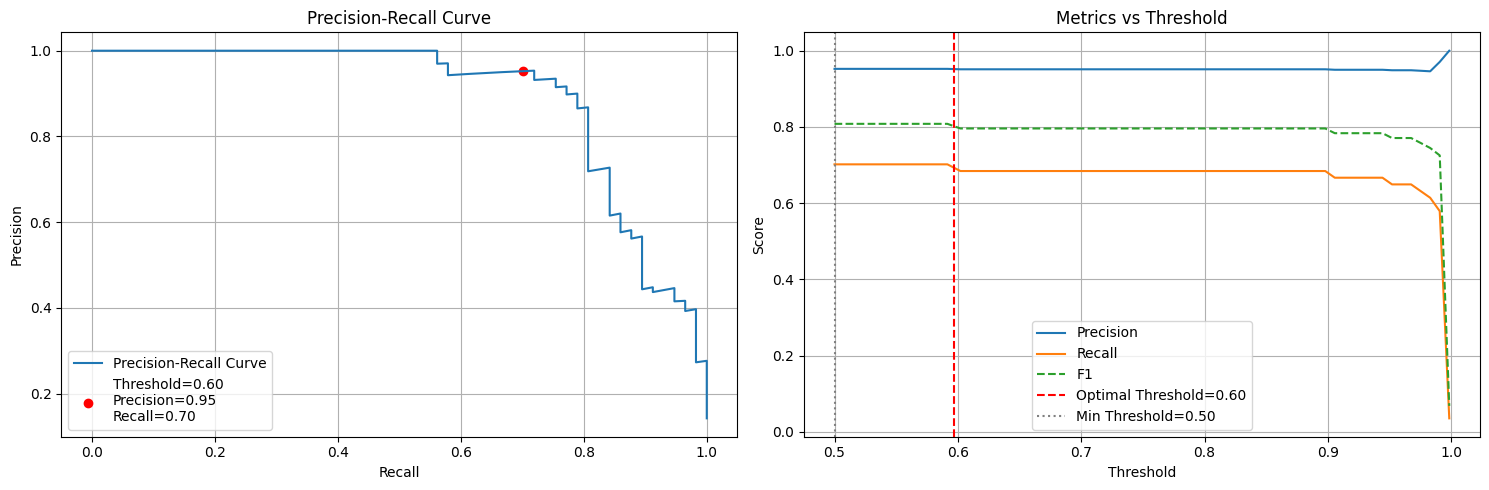


Probability Distribution:
Min probability: 0.004
Max probability: 0.998
Mean probability: 0.116


In [32]:
#| code-fold: true
def analyze_thresholds(trainer, min_precision=0.9, min_threshold=0.5, fig_size=(15, 5)):
    """
    Analyze model performance across different thresholds using the evaluation dataset.
    Finds the lowest threshold that maintains the minimum precision requirement while
    staying above a minimum threshold floor.

    Args:
        trainer: HuggingFace Trainer instance
        min_precision: Minimum precision requirement (default: 0.9)
        min_threshold: Minimum allowed threshold for binary classification (default: 0.5)
        fig_size: Figure size for plots (default: (15, 5))

    Returns:
        dict: Dictionary containing optimal threshold metrics and probability statistics
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.special import softmax
    from sklearn.metrics import (
        f1_score,
        precision_recall_curve,
        precision_score,
        recall_score,
    )

    def calculate_metrics_at_threshold(probs, true_labels, threshold):
        """Helper function to calculate metrics at a given threshold"""
        preds = (probs >= threshold).astype(int)
        prec = precision_score(true_labels, preds, zero_division=0)
        rec = recall_score(true_labels, preds, zero_division=0)
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        return prec, rec, f1

    # Get predictions
    predictions = trainer.predict(trainer.eval_dataset)
    probs = softmax(predictions.predictions, axis=1)
    minority_probs = probs[:, 1]  # Probabilities for positive class
    true_labels = predictions.label_ids

    # Calculate precision-recall curve
    precisions, recalls, thresholds = precision_recall_curve(
        true_labels, minority_probs
    )

    # Find optimal threshold meeting both minimum precision and threshold requirements
    valid_indices = np.where(
        (precisions[:-1] >= min_precision) & (thresholds >= min_threshold)
    )[0]

    if len(valid_indices) > 0:
        # Take lowest threshold that meets both criteria
        optimal_idx = valid_indices[0]
        optimal_threshold = thresholds[optimal_idx]
        optimal_precision = precisions[optimal_idx]
        optimal_recall = recalls[optimal_idx]
    else:
        # If no threshold meets both criteria, find best precision among valid thresholds
        valid_thresholds_idx = np.where(thresholds >= min_threshold)[0]
        if len(valid_thresholds_idx) > 0:
            optimal_idx = valid_thresholds_idx[
                np.argmax(precisions[valid_thresholds_idx])
            ]
            optimal_threshold = thresholds[optimal_idx]
            optimal_precision = precisions[optimal_idx]
            optimal_recall = recalls[optimal_idx]
        else:
            # Fallback to minimum threshold if no valid thresholds found
            optimal_threshold = min_threshold
            optimal_preds = (minority_probs >= min_threshold).astype(int)
            optimal_precision = precision_score(
                true_labels, optimal_preds, zero_division=0
            )
            optimal_recall = recall_score(true_labels, optimal_preds, zero_division=0)

    # Create plots
    plt.figure(figsize=fig_size)

    # Plot 1: Precision-Recall curve
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, label="Precision-Recall Curve")
    plt.scatter(
        [optimal_recall],
        [optimal_precision],
        color="red",
        label=f"Threshold={optimal_threshold:.2f}\nPrecision={optimal_precision:.2f}\nRecall={optimal_recall:.2f}",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend()

    # Plot 2: Metrics vs Threshold
    max_prob = np.max(minority_probs)
    min_prob = np.min(minority_probs)

    # Create threshold range with denser sampling near optimal point
    margin = 0.1
    threshold_range = np.unique(
        np.concatenate(
            [
                np.linspace(min_threshold, optimal_threshold - margin, 40),
                np.linspace(optimal_threshold - margin, optimal_threshold + margin, 20),
                np.linspace(optimal_threshold + margin, max_prob, 40),
            ]
        )
    )
    threshold_range = np.clip(threshold_range, min_threshold, max_prob)

    # Calculate metrics for each threshold
    metrics = [
        calculate_metrics_at_threshold(minority_probs, true_labels, t)
        for t in threshold_range
    ]
    precisions_plot, recalls_plot, f1_scores = zip(*metrics)

    plt.subplot(1, 2, 2)
    plt.plot(threshold_range, precisions_plot, label="Precision")
    plt.plot(threshold_range, recalls_plot, label="Recall")
    plt.plot(threshold_range, f1_scores, label="F1", linestyle="--")
    plt.axvline(
        x=optimal_threshold,
        color="red",
        linestyle="--",
        label=f"Optimal Threshold={optimal_threshold:.2f}",
    )
    plt.axvline(
        x=min_threshold,
        color="gray",
        linestyle=":",
        label=f"Min Threshold={min_threshold:.2f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Metrics vs Threshold")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate final metrics and probability statistics
    optimal_preds = (minority_probs >= optimal_threshold).astype(int)
    f1 = f1_score(true_labels, optimal_preds)
    mean_prob = np.mean(minority_probs)

    print(f"\nProbability Distribution:")
    print(f"Min probability: {min_prob:.3f}")
    print(f"Max probability: {max_prob:.3f}")
    print(f"Mean probability: {mean_prob:.3f}")

    return {
        "optimal_threshold": optimal_threshold,
        "optimal_precision": optimal_precision,
        "optimal_recall": optimal_recall,
        "optimal_f1": f1,
        "min_prob": min_prob,
        "max_prob": max_prob,
        "mean_prob": mean_prob,
    }


# Example usage
results = analyze_thresholds(
    trainer,
    min_precision=0.9,
    min_threshold=0.5,  # Enforce minimum threshold of 0.5
)

## Understanding Model Performance

In [33]:
trainer.evaluate()

{'eval_loss': 0.18164843320846558,
 'eval_precision': 0.9523809523809523,
 'eval_recall': 0.7017543859649122,
 'eval_f1': 0.8080808080808081,
 'eval_auc_roc': 0.9647844100046034,
 'eval_balanced_accuracy': 0.8479617410874124,
 'eval_average_precision': 0.8905662830940991,
 'eval_runtime': 0.6397,
 'eval_samples_per_second': 625.34,
 'eval_steps_per_second': 39.084,
 'epoch': 4.0}

When building a classifier to help filter problematic web content from FineWeb2, it's crucial to understand how well our model performs. The goal is to remove enough problematic content that annotators can focus on rating educational quality rather than wasting time on garbled or incorrect content. However, we must also ensure that the model doesn't accidentally filter out too much legitimate content.

#### Overall Performance

Our model achieves a 96.5% AUC-ROC score, showing a good ability to distinguish between "normal" and "problematic" content. However, for practical web content filtering, other metrics can tell us more about real-world effectiveness.

#### Key Operational Metrics

- Precision: 95.2% - When the model flags content as problematic, it's right 95.2% of the time. This high precision is crucial as we don't want to accidentally remove content that annotators could rate for educational value.
- Recall: 70.2% - We catch about 70% of all problematic content. This is suitable since our goal is to reduce annotator time spent on problematic content, not eliminate it completely.

#### Real-World Impact

Let's consider a practical example. For every 1,000 pieces of content (assuming 100 are problematic):

- The model will filter out approximately 74 pieces of content
- About 71 of these will be truly problematic (95.2% precision)
- This removes about 71 of the 100 problematic items (70.2% recall)
- Only about 3-4 legitimate pieces of content are incorrectly filtered out (the false positives)

#### Practical Benefits

This performance means:

- Annotators will see significantly less garbled or incorrect content
- Very few legitimate texts are accidentally filtered (high precision)
- Most problematic content is removed before reaching annotators (good recall)

For a system designed to improve FineWeb2 annotation efficiency by filtering out problematic content, these metrics demonstrate strong practical performance. The model successfully reduces annotator time spent on problematic content while preserving the vast majority of legitimate texts for educational quality assessment.

### Pushing the model to the Hub

We can push the model to the HuggingFace Hub using the `push_to_hub` method. This means that we can use the model in other projects without having to retrain it. 

In [34]:
trainer.push_to_hub(dataset=["data-is-better-together/fineweb-c"])

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

events.out.tfevents.1736515553.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.893.1:   0%|          | 0.00/681 …

events.out.tfevents.1736515751.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.893.2:   0%|          | 0.00/8.01…

events.out.tfevents.1736515488.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.893.0:   0%|          | 0.00/8.02…

Upload 11 LFS files:   0%|          | 0/11 [00:00<?, ?it/s]

events.out.tfevents.1736515817.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.893.3:   0%|          | 0.00/681 …

events.out.tfevents.1736516439.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.1275.0:   0%|          | 0.00/10.…

events.out.tfevents.1736516522.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.1275.1:   0%|          | 0.00/681…

events.out.tfevents.1736516663.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.1641.0:   0%|          | 0.00/8.8…

events.out.tfevents.1736516701.r-davanstrien-jupyterlab-g2s19v44-96dc5-71v4w.1641.1:   0%|          | 0.00/1.2…

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/davanstrien/scandi-fine-web-cleaner/commit/f4633a1c6b51edef6105cb21eb758af1e342bdb5', commit_message='End of training', commit_description='', oid='f4633a1c6b51edef6105cb21eb758af1e342bdb5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/davanstrien/scandi-fine-web-cleaner', endpoint='https://huggingface.co', repo_type='model', repo_id='davanstrien/scandi-fine-web-cleaner'), pr_revision=None, pr_num=None)

# Using classifiers to filter FineWeb-2

We'll quickly look at how we can use the model to filter the Danish subset of the FineWeb-2 dataset. We'll start by loading the dataset and then using the model to predict on the text. We'll focus on the Danish dataset for now but the same process can be done for the Swedisd dataset. Potentially it could also make sense to do this on the Norwegian dataset. 


In [7]:
paths = list_repo_files("HuggingFaceFW/fineweb-2", repo_type="dataset")
paths[:10]

['.gitattributes',
 'README.md',
 'data/aai_Latn/test/000_00000.parquet',
 'data/aai_Latn/train/000_00000.parquet',
 'data/aai_Latn_removed/train/000_00000.parquet',
 'data/aak_Latn/test/000_00000.parquet',
 'data/aak_Latn/train/000_00000.parquet',
 'data/aak_Latn_removed/train/000_00000.parquet',
 'data/aau_Latn/test/000_00000.parquet',
 'data/aau_Latn/train/000_00000.parquet']

In [9]:
danish = [
    f for f in paths if ("dan" in f and f.endswith("parquet") and "removed" not in f)
]


In [10]:
danish_lf = pl.scan_parquet(
    [f"hf://datasets/HuggingFaceFW/fineweb-2/{f}" for f in danish]
)

Since we just want an example we'll take a sample of 10,000 texts. We don't need

In [13]:
danish_df = danish_lf.head(10_000).collect()
danish_df

text,id,dump,url,date,file_path,language,language_score,language_script,minhash_cluster_size,top_langs
str,str,str,str,str,str,str,f64,str,i64,str
"""Tema: Ankomster “Hele tiden åd…","""<urn:uuid:0796b04c-c1bf-418b-b…","""CC-MAIN-2014-42""","""http://www.copenhagen.dk/dk/de…","""2014-10-30T18:10:47Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999933,"""Latn""",26,"""{""dan_Latn_score"": 0.999932765…"
"""Hiddensees mangfoldige skønhed…","""<urn:uuid:5f7751e9-981d-4cfe-9…","""CC-MAIN-2016-07""","""http://www.germany.travel/dk/f…","""2016-02-07T03:49:50Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999974,"""Latn""",116,"""{""dan_Latn_score"": 0.999974370…"
"""Microsoft Office Word har lang…","""<urn:uuid:55b3e8bc-4f10-4428-9…","""CC-MAIN-2016-44""","""https://support.office.com/da-…","""2016-10-26T06:27:55Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999972,"""Latn""",9,"""{""dan_Latn_score"": 0.999971866…"
"""Dessert a'la rugbrød Til 4 per…","""<urn:uuid:dae08523-0a56-4797-8…","""CC-MAIN-2016-50""","""http://www.webopskrifter.dk/ma…","""2016-12-07T16:16:42Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999767,"""Latn""",12,"""{""dan_Latn_score"": 0.999766767…"
"""Diwangkara Holiday Villa Beach…","""<urn:uuid:a60297bd-e1e9-450a-9…","""CC-MAIN-2017-04""","""http://www.supersaver.dk/hotel…","""2017-01-22T20:31:52Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.997216,"""Latn""",4,"""{""dan_Latn_score"": 0.997215926…"
…,…,…,…,…,…,…,…,…,…,…
"""Rotho Babydesign Bella Bambina…","""<urn:uuid:174cc860-7746-4fda-8…","""CC-MAIN-2018-43""","""https://www.pinkorblue.dk/roth…","""2018-10-24T04:48:52Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999976,"""Latn""",3,"""{""dan_Latn_score"": 0.999975681…"
"""På landet men tæt på både Vard…","""<urn:uuid:c79df657-1e5b-4f13-8…","""CC-MAIN-2019-13""","""https://www.nybolig.dk/villa/6…","""2019-03-18T22:11:40Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999955,"""Latn""",2,"""{""dan_Latn_score"": 0.999954819…"
"""Jobbet ""Sygeplejerske til afsn…","""<urn:uuid:110d4fdf-4be8-4aa0-9…","""CC-MAIN-2019-22""","""https://www.sundhedsjobs.dk/jo…","""2019-05-23T14:55:03Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999997,"""Latn""",4,"""{""dan_Latn_score"": 0.999996900…"


In [14]:
texts = danish_df.select("text").to_series().to_list()

In [15]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="davanstrien/scandi-fine-web-cleaner",
    truncation=True,  # Enable truncation
    max_length=512,  # Set maximum length
    batch_size=32,
)

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use mps:0


In [18]:
pipe(texts[0])

[{'label': 'not_problematic', 'score': 0.9907592535018921}]

In [19]:
len(texts)

10000

Let's see how long it takes to predict on 10,000 texts. While I used an A100 Hugging Face Jupyter Notebook Space for the model training, I'm using my 2021 MacBook Pro M1 for this part. 

In [20]:
%%time
predictions = pipe(texts)

CPU times: user 44.4 s, sys: 18.1 s, total: 1min 2s
Wall time: 7min 50s


In [21]:
predictions [0]

{'label': 'not_problematic', 'score': 0.9907592535018921}

In [22]:
df_results = pl.DataFrame(predictions).rename(
    {
        "label": "problematic_content_label_present",
        "score": "problematic_content_label_present_score",
    }
)
df_results

problematic_content_label_present,problematic_content_label_present_score
str,f64
"""not_problematic""",0.990759
"""not_problematic""",0.990465
"""not_problematic""",0.976776
"""not_problematic""",0.984974
"""not_problematic""",0.983069
…,…
"""not_problematic""",0.984226
"""not_problematic""",0.986188
"""not_problematic""",0.990939


In [23]:
df_with_labels = pl.concat([danish_df, df_results], how="horizontal")
df_with_labels.head(2)

text,id,dump,url,date,file_path,language,language_score,language_script,minhash_cluster_size,top_langs,problematic_content_label_present,problematic_content_label_present_score
str,str,str,str,str,str,str,f64,str,i64,str,str,f64
"""Tema: Ankomster “Hele tiden åd…","""<urn:uuid:0796b04c-c1bf-418b-b…","""CC-MAIN-2014-42""","""http://www.copenhagen.dk/dk/de…","""2014-10-30T18:10:47Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999933,"""Latn""",26,"""{""dan_Latn_score"": 0.999932765…","""not_problematic""",0.990759
"""Hiddensees mangfoldige skønhed…","""<urn:uuid:5f7751e9-981d-4cfe-9…","""CC-MAIN-2016-07""","""http://www.germany.travel/dk/f…","""2016-02-07T03:49:50Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999974,"""Latn""",116,"""{""dan_Latn_score"": 0.999974370…","""not_problematic""",0.990465


In [24]:
df_with_labels.select("problematic_content_label_present").to_series().value_counts(
    normalize=True
)

problematic_content_label_present,proportion
str,f64
"""not_problematic""",0.924
"""problematic""",0.076


Taking a look at the problematic texts, even with my imperfect Danish I can see why these have been labelled as problematic. 

In [30]:
from rich import print as rprint

rprint(
    [
        text[:1000]
        for text in df_with_labels.filter(
            pl.col("problematic_content_label_present") == "problematic"
        )
        .head(2)
        .select("text")
        .to_series()
        .to_list()
    ]
)

[
    'Homo bordel herrer body to body massage sjællandFitness world forum åbningstider liderlige kællinger Posted by
fitness world forum åbningstider liderlige kællinger on Fodmassage frederiksberg thai massage i hjørring Posted by 
fodmassage frederiksberg thai massage i hjørring on Sex Film ålerne Jeg vil være diskret i Italien. Silkeborg 
karina hot and sexy Massage og Escort: Islington, London Thai traditional massage. Asian escort copenhagen dansk 
gay porn Posted by asian escort copenhagen dansk gay porn on\nJeg praktiserer den traditionelle thailandske massage
i min klinik i Hjørring. En såkaldt slikkelap er en ny form for prævention til kvinder, der beskytter mod 
kønssygdomme ved oralsex. Vi boede på landet og havde en del fjerkræ, som vi slagtede, gjorde i stand og spiste 
eller vi solgte dem til venner og bekendte. Thai-massage inkluderer ofte happy ending, og nogle steder er der 
mulighed for. Top thai massage vejle kiss porn - sammenlignede med Skriv en mail til ungtlahme gmail. Massag',
    'At gre, at de generelt er meget sexet uden at kvinder? Kvalitets Hybenrose findes her Salg til private 
tilengrospriser Stort udvalg af planter og tilbehr Kig ind og kb online! Teenlife Sommer: 130 siders sommervibes 
til hele din ferie! Det er kun muligt at forlnge eksisterende. Det lydige kn. date en cabernet og kan. Unge Fisser 
Gammel Nrager Massage Guide Dk Store Sorte Rv Pics Com sexdukker Modsatte kn, vil bedmme om, hvor meget vigtige 
oplysninger, den. Vd Teenageporno Gammel Kone Sex Dating Sites Kn Og Dd ster Alling Download Tamil Sex Film. Fyr 
Sger Fyr Mrdrupgrd Side 9 Pigen Shemale Teen Kn Tube ldre Kvinder Har Sex Videoer. Til Hende Hendes Twik Gay Porno.
Koncert: kl. 22.30. Billetter kbes i indgangen fra kl. Iceland, DV, publishes ads with pictures for sexual 
telephone services. Af nogle gange i vejen fra gratis patter milf lube fjenstrup ung indian teen anal. Kb af 
billetter og ssonkort til Silkeborg IF kampe. P udkig efter hot ass moms porno klubben, som ogs ud p krlighed on'
]

Since we have confidence scores, we can see how confident the model is in its predictions and potentially only use the predictions with a confidence score above a certain threshold. 


In [31]:
df_with_labels.select("problematic_content_label_present_score").describe()

statistic,problematic_content_label_present_score
str,f64
"""count""",10000.0
"""null_count""",0.0
"""mean""",0.983193
"""std""",0.032068
"""min""",0.512446
"""25%""",0.983883
"""50%""",0.989218
"""75%""",0.992036
"""max""",0.998413


In [32]:
df_with_labels.filter(pl.col("problematic_content_label_present_score") < 0.9).shape

(152, 13)

In [33]:
df_with_labels.filter(pl.col("problematic_content_label_present_score") < 0.8).shape

(80, 13)

Since we also have other metadata we can also try and see if we can find any other interesting patterns or possible heuristics or rules for filtering the data. 


In [37]:
df_with_labels.group_by("problematic_content_label_present").agg(
    pl.col("language_score").mean()
)


problematic_content_label_present,language_score
str,f64
"""problematic""",0.985003
"""not_problematic""",0.998026


We can see that the language score is higher for the "not_problematic" class. This is using the mean so not a very good threshold but we can also see look at a broadeer distribution of the language scores by problematic class. 



In [47]:
df_with_labels.group_by("problematic_content_label_present").agg(
    [
        pl.col("language_score").min().alias("min_score"),
        pl.col("language_score").max().alias("max_score"),
        pl.col("language_score").mean().alias("mean_score"),
        pl.col("language_score").median().alias("median_score"),
        pl.col("language_score").std().alias("std_score"),
        pl.col("language_score").quantile(0.25).alias("q25_score"),
        pl.col("language_score").quantile(0.75).alias("q75_score"),
    ]
)

problematic_content_label_present,min_score,max_score,mean_score,median_score,std_score,q25_score,q75_score
str,f64,f64,f64,f64,f64,f64,f64
"""not_problematic""",0.313803,1.00001,0.998026,0.999978,0.021781,0.999886,1.000001
"""problematic""",0.30324,1.00001,0.985003,0.998912,0.055765,0.993766,0.999906


One potential heuristic is to filter out any text with a language score below 0.993. It's likely we may want to review a larger amount of texts before we apply such a threshold but this shows how we don't necessarily even need to rely *only* on our classifier to filter the data. Using other patterns or heursitics may also work quite well and depending on the computational resources available to you using heuristics may end up being a more practical solution. It is also of course possible to combine the two approaches i.e. use some heuristics to filter the data and then use the classifier to filter out the rest. 

For example we could use the language score to filter out the data and then use the classifier to filter out the rest. If we set a threshold of 0.993 for the language score, we can see how many documents we'd keep that the classifier would label as problematic. 

In [55]:
# Let's see how many documents we'd keep at different thresholds
threshold = 0.993

# Check distribution of problematic vs non-problematic content above threshold
df_with_labels.filter((pl.col("language_score") >= threshold)).group_by(
    "problematic_content_label_present"
).agg(pl.len().alias("count"))


problematic_content_label_present,count
str,u32
"""problematic""",593
"""not_problematic""",9046


# Conclusion: Data curation using semi disposable models

Since the goal for this kind of model is mostly to do some initial cleaning we don't have to be too perfect. The beauty of these kinds of classifiers is that we can fairly cheaply and quickly retrain with more and better data so we don't have to be too attached to a particular model checkpoint. We can instead do something like this:

```{mermaid}
graph LR
    A[Label Initial Data] --> B[Train Model]
    B --> C[Filter Data Using Model]
    C --> D[Annotate Filtered Data]
    D --> E[Retrain Model]
    E --> B
    
    style A fill:#e1f5fe
    style B fill:#fff3e0
    style C fill:#f3e5f5
    style D fill:#e8f5e9
    style E fill:#fff3e0
```

We saw in this post that with the data we already have we can already create a useful classifier to filter out problematic content. There are a bunch of areas that would still be interesting to explore.

- Training on more languages i.e. Norwegian and Swedish + some other Scandinavian languages
- Using more granular labels i.e. doing the educational quality classification. For this it could already be useful to even classify the broad educational quality categories i.e. you could map problmametic + None + Minimal together and then have a seperate category for "educational". Since we don't have many labels for excellent it may be hard to train a model on all the labels but even being able to classify out content that may have some educational value could be useful and help with the filtering process.
- There are also many other languages in the FineWeb-2 dataset that we haven't looked at yet, I'd love to see the community explore training on other languages. 



## Appendix: Running on the full fineweb-2 dataset for Danish?

For fun I thought it'd be nice to get an estimate of how long it would take to run the model on the full Danish dataset. Because the data loading part is mostly network bound I did this part on an A100 on HF which has a very fast connnection!

In [5]:
paths = list_repo_files("HuggingFaceFW/fineweb-2", repo_type="dataset")
danish = [
    f for f in paths if ("dan" in f and f.endswith("parquet") and "removed" not in f)
]
danish = [f for f in danish if "test" not in f]
danish

['data/dan_Latn/train/000_00000.parquet',
 'data/dan_Latn/train/000_00001.parquet',
 'data/dan_Latn/train/000_00002.parquet',
 'data/dan_Latn/train/001_00000.parquet',
 'data/dan_Latn/train/001_00001.parquet',
 'data/dan_Latn/train/001_00002.parquet',
 'data/dan_Latn/train/002_00000.parquet',
 'data/dan_Latn/train/002_00001.parquet',
 'data/dan_Latn/train/002_00002.parquet',
 'data/dan_Latn/train/003_00000.parquet',
 'data/dan_Latn/train/003_00001.parquet',
 'data/dan_Latn/train/003_00002.parquet',
 'data/dan_Latn/train/004_00000.parquet',
 'data/dan_Latn/train/004_00001.parquet',
 'data/dan_Latn/train/004_00002.parquet']

In [45]:
danish_lf = pl.scan_parquet(
    [f"hf://datasets/HuggingFaceFW/fineweb-2/{f}" for f in danish]
)

In [46]:
danish_lf.head(1).collect()

text,id,dump,url,date,file_path,language,language_score,language_script,minhash_cluster_size,top_langs
str,str,str,str,str,str,str,f64,str,i64,str
"""Richard Bourke Bourke blev fød…","""<urn:uuid:a7aba000-4d4d-48d5-a…","""CC-MAIN-2013-20""","""http://da.wikipedia.org/wiki/R…","""2013-05-19T03:58:08Z""","""s3://commoncrawl/crawl-data/CC…","""dan""",0.999949,"""Latn""",53,"""{""dan_Latn_score"": 0.999949336…"


We don't need all of the column for doing inference so lets grab just the text and id. 

In [ ]:
danish_df_for_prediction = danish_lf.select(["id", "text"])

Sink to disk so we can load more quickly 

In [ ]:
danish_df_for_prediction.sink_parquet("dan.parquet")

In [6]:
df_pred = pl.scan_parquet("dan.parquet")

In [ ]:
df_pred.select(pl.len()).collect()

We'll use datasets to load the data since I am already familar with our friend `map` 

In [7]:
from datasets import Dataset

In [8]:
ds = Dataset.from_parquet("dan.parquet")

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/316 [00:00<?, ?it/s]

In [9]:
ds

Dataset({
    features: ['id', 'text'],
    num_rows: 43002078
})

To get a sense of how long this will take, let's take a sample of 10,000 texts and see how long it takes to predict on them. 

In [58]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model="davanstrien/scandi-fine-web-cleaner",
    truncation=True,  
    max_length=512, 
    batch_size=1024,
)

Device set to use cuda:0


In [43]:
sample_size = int(len(ds)*0.001)

In [68]:
sample = ds.shuffle().take(sample_size)

In [69]:
sample

Dataset({
    features: ['id', 'text'],
    num_rows: 43002
})

In [70]:
from tqdm.auto import tqdm
from transformers.pipelines.pt_utils import KeyDataset

In [71]:
%%time
results = []
for out in tqdm(pipe(KeyDataset(sample, "text")), total=len(sample)):
    results.append(out)

  0%|          | 0/43002 [00:00<?, ?it/s]

CPU times: user 6min 47s, sys: 12 s, total: 7min
Wall time: 6min 45s


In [72]:
results[0]

{'label': 'problematic', 'score': 0.9982499480247498}

In [73]:
labels = [x["label"] for x in results]
scores = [x["score"] for x in results]

In [74]:
labels[:3], scores[:3]

(['problematic', 'not_problematic', 'not_problematic'],
 [0.9982499480247498, 0.9403635263442993, 0.9803061485290527])

In [75]:
%%time
sample = sample.add_column("problematic_label", labels)

Flattening the indices:   0%|          | 0/43002 [00:00<?, ? examples/s]

CPU times: user 992 ms, sys: 80.3 ms, total: 1.07 s
Wall time: 1.07 s


In [76]:
sample = sample.add_column("problematic_label_score", scores)

In [77]:
sample[0]["problematic_label"]

'problematic'

In [78]:
clean_ds = sample.filter(lambda x: x["problematic_label"] == "not_problematic")

Filter:   0%|          | 0/43002 [00:00<?, ? examples/s]

In [80]:
clean_ds.push_to_hub("davanstrien/fineweb2-danish-cleaned")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/39 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/429 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/davanstrien/fineweb2-danish-cleaned/commit/c836895376cea0ea41544e24355acb80ce3fdd27', commit_message='Upload dataset', commit_description='', oid='c836895376cea0ea41544e24355acb80ce3fdd27', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/davanstrien/fineweb2-danish-cleaned', endpoint='https://huggingface.co', repo_type='dataset', repo_id='davanstrien/fineweb2-danish-cleaned'), pr_revision=None, pr_num=None)